# Optimisation

This notebook searches for a robust policy. The problem is first initialised, and then a set of 'good' policies are found through doing a direct search. Problem formulation 2 is used as this provides a cost analysis of all the locations. Performing an analysis over all locations will assist in coming up with the best overall policy

In [2]:
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from problem_formulation import get_model_for_problem_formulation


ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [3]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)
from dike_model_function import DikeNetwork  # @UnresolvedImport


def sum_over(*args):
    return sum(args)

In [4]:
#enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
for unc in dike_model.uncertainties:
    print(repr(unc))
    
uncertainties = dike_model.uncertainties

import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132)
RealParameter('A.1_Bmax', 30, 350)
RealParameter('A.1_pfail', 0, 1)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350)
RealParameter('A.2_pfail', 0, 1)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350)
RealParameter('A.3_pfail', 0, 1)
CategoricalParameter('A.3_Brate', [0, 1, 2])
RealParameter('A.4_Bmax', 30, 350)
RealParameter('A.4_pfail', 0, 1)
CategoricalParameter('A.4_Brate', [0, 1, 2])
RealParameter('A.5_Bmax', 30, 350)
RealParameter('A.5_pfail', 0, 1)
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [5]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.0.4
2.4


# 1.1 Search for candidate solutions

The fundamental problem is fine tuning the robustness functions. To do this, rather than run optimizaitons many times, we will first generate a test set with several policies and then apply robustness functions and visualize the results. This provides faster feedback on cut-off values.

In [6]:
from ema_workbench.em_framework import sample_uncertainties
n_scenarios = 10
scenarios = sample_uncertainties(dike_model, n_scenarios)
nfe = int(1000)

from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

In [12]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios,              
                                            policies=100)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10 scenarios * 100 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [13]:
# The policy runs will be saved to be used later if necessary (policies = 100)

from ema_workbench import save_results, load_results
save_results(results, "Problem_Formulation_2_Policies_100.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\Github Assignment Collaboration\final assignment\Problem_Formulation_2_Policies_100.tar.gz


In [8]:
from ema_workbench import save_results, load_results
results = load_results("Problem_Formulation_2_Policies_100.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\Github Assignment Collaboration\final assignment\Problem_Formulation_2_Policies_100.tar.gz


In [9]:
experiments, outcomes = results

The cut-off values will be visualised using violin plots

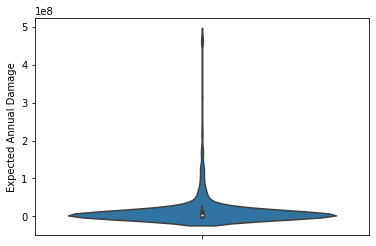

In [15]:
# Violin plot for the Expected Annual Damage

data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(y = 'Expected Annual Damage', data=data)

plt.show()

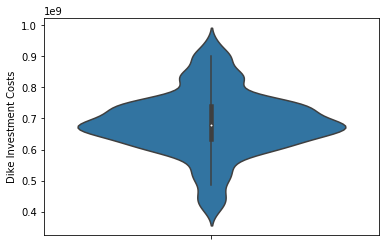

In [16]:
# Violin plot for the Dike Investment Costs

data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(y = 'Dike Investment Costs', data=data)

plt.show()

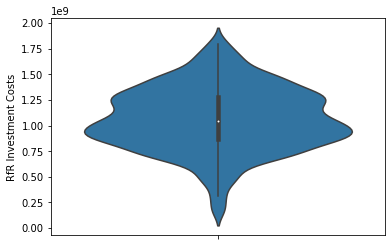

In [17]:
# Violin plot for the RfR Investment Costs

data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(y = 'RfR Investment Costs', data=data)

plt.show()

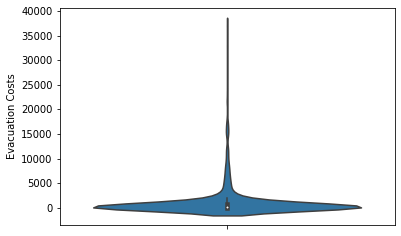

In [18]:
# Violin plot for the Evacuation Costs

data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(y = 'Evacuation Costs', data=data)

plt.show()

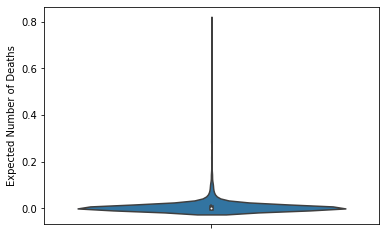

In [19]:
# Violin plot for the Evacuation Costs

data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(y = 'Expected Number of Deaths', data=data)

plt.show()

From the violin plots we get the cut-off values, which are inserted in the robustness function

In [21]:
outcomes.keys()

dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'])

In [10]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'

Expected_Annual_Damage = functools.partial(robustness, SMALLER, 5e3) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Dike_Investment_Costs =  functools.partial(robustness, SMALLER, 7e8) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
RfR_Investment_Costs =  functools.partial(robustness, SMALLER, 1e9) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Evacuation_Costs =  functools.partial(robustness, SMALLER, 5e3) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 1e-5) # Number needs to be specified



Find policies that comply to these robustness cut-off functions

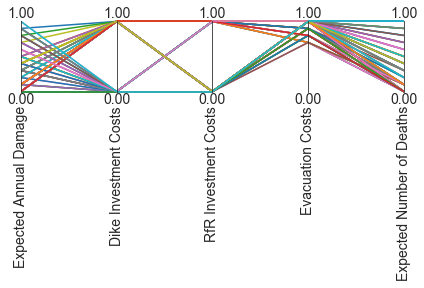

In [52]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results

funcs = {'Expected Annual Damage': Expected_Annual_Damage,
         'Dike Investment Costs': Dike_Investment_Costs,
         'RfR Investment Costs': RfR_Investment_Costs,
         'Evacuation Costs': Evacuation_Costs,
         'Expected Number of Deaths': Expected_Number_of_Deaths}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [58]:
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

BaseEvaluator.reporting_frequency = 0.1

ema_logging.log_to_stderr(ema_logging.INFO)

# there is a bit of problem with platypus, so using 1.1. gives 
# cleaner hypervolume results.
convergence = [HyperVolume(minimum=[0,0,0], maximum=[1.1, 1.1, 1.1]),
              EpsilonProgress()]

epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
with MultiprocessingEvaluator(dike_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios,nfe=nfe,
                                                     convergence=convergence, epsilons=epsilons)
    
#start = time.time()
#end = time.time()

#print('Processing time:',(end-start)/60,'Minutes')    

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe


IndexError: list index out of range

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [ ]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [ ]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'

Expected_Annual_Damage = functools.partial(robustness, SMALLER, 5e3) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Dike_Investment_Costs =  functools.partial(robustness, SMALLER, 7e8) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
RfR_Investment_Costs =  functools.partial(robustness, SMALLER, 1e9) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Evacuation_Costs =  functools.partial(robustness, SMALLER, 5e3) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 1e-5) # Number needs to be specified

Set-up for the robust-optimization

In [11]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Annual Damage': Expected_Annual_Damage,
         'Dike Investment Costs': Dike_Investment_Costs,
         'RfR Investment Costs': RfR_Investment_Costs,
         'Evacuation Costs': Evacuation_Costs,
         'Expected Number of Deaths':Expected_Number_of_Deaths}

# We want to minimize costs, damage and deaths

robustnes_functions = [ScalarOutcome('Fraction EA Damage', kind=MINIMIZE, 
                             variable_name='Expected Annual Damage', function=Expected_Annual_Damage),
                       ScalarOutcome('D Investment Costs', kind=MINIMIZE, 
                             variable_name='Dike Investment Costs', function=Dike_Investment_Costs),
                       ScalarOutcome('RfR Investment costs', kind=MINIMIZE,
                             variable_name='RfR Investment Costs', function=RfR_Investment_Costs),
                      ScalarOutcome('Evac Costs', kind=MINIMIZE, 
                             variable_name='Evacuation Costs', function=Evacuation_Costs),
                       ScalarOutcome('Expected Num Deaths', kind=MINIMIZE,
                             variable_name='Expected Number of Deaths', function=Expected_Number_of_Deaths)]




In [13]:
# we have to change the plausible max for total investment costs

from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

convergence = [HyperVolume(minimum=[0,0,0,0,0], maximum=[1.1, 1.1, 1.1, 1.1, 3]),
              EpsilonProgress()]

epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
with MultiprocessingEvaluator(dike_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe,
                                                     convergence=convergence, epsilons=epsilons, population_size = 20,
                                                    convergence_freq = 20)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 500/1000 nfe
[MainProcess/INFO] generation 10: 996/1000 nfe
[MainProcess/INFO] optimization completed, found 3 solutions
[MainProcess/INFO] terminating pool


In [26]:
save_results([archive, convergence], 'Robust_Optimise_1000nfe')

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\Github Assignment Collaboration\final assignment\Robust_Optimise_1000nfe


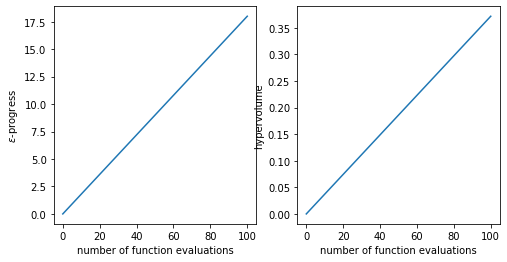

In [14]:
# Plot the epsilon progress and convergence

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

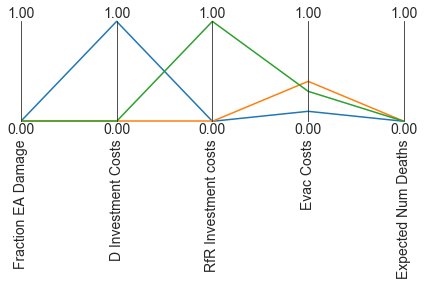

In [16]:
from ema_workbench.analysis import parcoords


data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [21]:
archive.iloc[:,0:10]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0
0,0,1,1,1,1,1,0,0,0,0
1,0,0,1,1,0,1,0,1,0,0
2,0,0,0,0,1,1,0,0,0,0


In [22]:
archive.iloc[:,10:26]

,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0
0,0,0,1,1,0,3,6,4,3,0,9,0,1,7,5,3
1,0,0,1,1,0,3,9,9,7,1,10,5,1,1,10,6
2,0,0,0,1,0,3,9,6,4,4,5,10,0,10,3,9


In [23]:
archive.iloc[:,26:36]

,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Fraction EA Damage,D Investment Costs,RfR Investment costs,Evac Costs,Expected Num Deaths
0,8,4,0,1,0,0.0,1.0,0.0,0.1,0.0
1,2,7,0,7,5,0.0,0.0,0.0,0.4,0.0
2,3,5,1,2,3,0.0,0.0,1.0,0.3,0.0


In [25]:
pd.DataFrame(outcomes)

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,0.0,6.445702e+08,6.984000e+08,0.0,0.0
1,0.0,6.445702e+08,6.984000e+08,0.0,0.0
2,0.0,6.445702e+08,6.984000e+08,0.0,0.0
3,0.0,6.445702e+08,6.984000e+08,0.0,0.0
4,0.0,6.445702e+08,6.984000e+08,0.0,0.0
...,...,...,...,...,...
995,0.0,7.539307e+08,1.026200e+09,0.0,0.0
996,0.0,7.539307e+08,1.026200e+09,0.0,0.0
997,0.0,7.539307e+08,1.026200e+09,0.0,0.0
998,0.0,7.539307e+08,1.026200e+09,0.0,0.0


# 1.2 Re-evaluate candidate solutions under uncertainty

In [ ]:
from ema_workbench import Policy

policies = archive.drop([o.name for o in robustnes_functions], axis=1)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy("moro {}".format(i), **policy.to_dict()))

In [ ]:
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

#start = time.time()
#end = time.time()

#print('Processing time:',(end-start)/60,'Minutes')

In [ ]:
from ema_workbench import save_results

save_results(results, 'MORO_reevaluation.tar.gz')

In [ ]:
policies.to_csv('moro polices.csv')

In [ ]:
import pandas as pd
experiments, outcomes = results

overall_robustness = {}
for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness

In [ ]:
data = overall_robustness.loc[:, ['Expected Annual Damage','Dike Investment Costs','RfR Investment Costs','Evacuation Costs', 'Expected Number of Deaths']]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()